In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

In [3]:
data_dir = "../data"  

# Funcion para contar número de imagenes en cada carpeta
def count_images_folders(root_dir):
    total = 0
    category_counts = {}
    for folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            emotion_count = {}
            num_images =  len(os.listdir(folder_path))             
            print(f"{num_images} images in {folder} folder")
            total += num_images
            print(f"Total images: {total}")
            category_counts[folder] = num_images

    return category_counts


# Contamos imagenes en train y test
print("Train Folder:")
train_category_counts = count_images_folders(os.path.join(data_dir, "train1"))

print("Validation Folder:")
validation_category_counts = count_images_folders(os.path.join(data_dir, "validation"))

print("\nTest Folder:")
test_category_counts = count_images_folders(os.path.join(data_dir, "test"))


Train Folder:
1998 images in angry folder
Total images: 1998
218 images in disgust folder
Total images: 2216
2049 images in fear folder
Total images: 4265
3608 images in happy folder
Total images: 7873
2483 images in neutral folder
Total images: 10356
2415 images in sad folder
Total images: 12771
1586 images in surprise folder
Total images: 14357
Validation Folder:
1997 images in angry folder
Total images: 1997
218 images in disgust folder
Total images: 2215
2048 images in fear folder
Total images: 4263
3607 images in happy folder
Total images: 7870
2482 images in neutral folder
Total images: 10352
2415 images in sad folder
Total images: 12767
1585 images in surprise folder
Total images: 14352

Test Folder:
958 images in angry folder
Total images: 958
111 images in disgust folder
Total images: 1069
1024 images in fear folder
Total images: 2093
1774 images in happy folder
Total images: 3867
1233 images in neutral folder
Total images: 5100
1247 images in sad folder
Total images: 6347
831

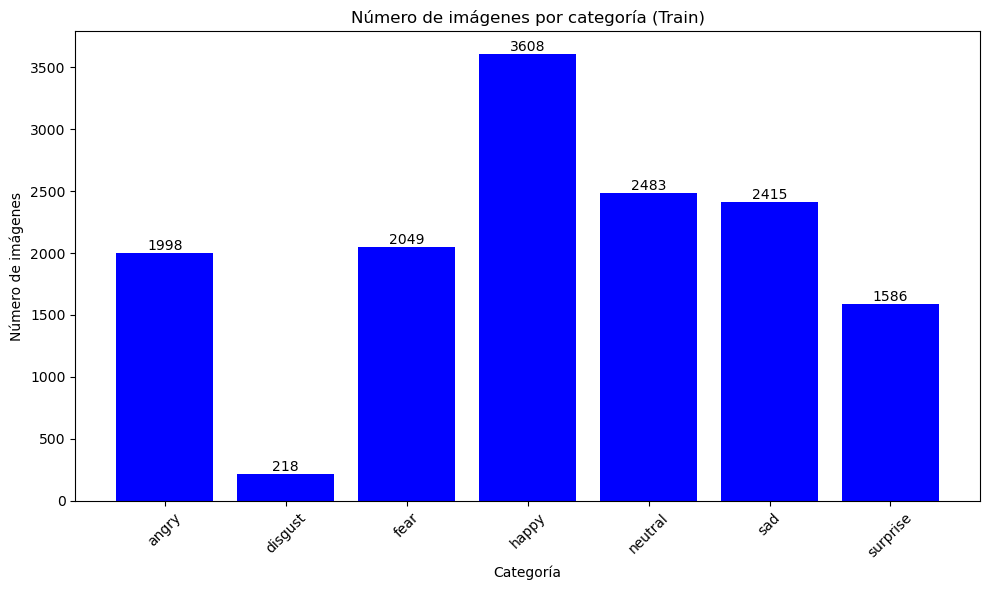

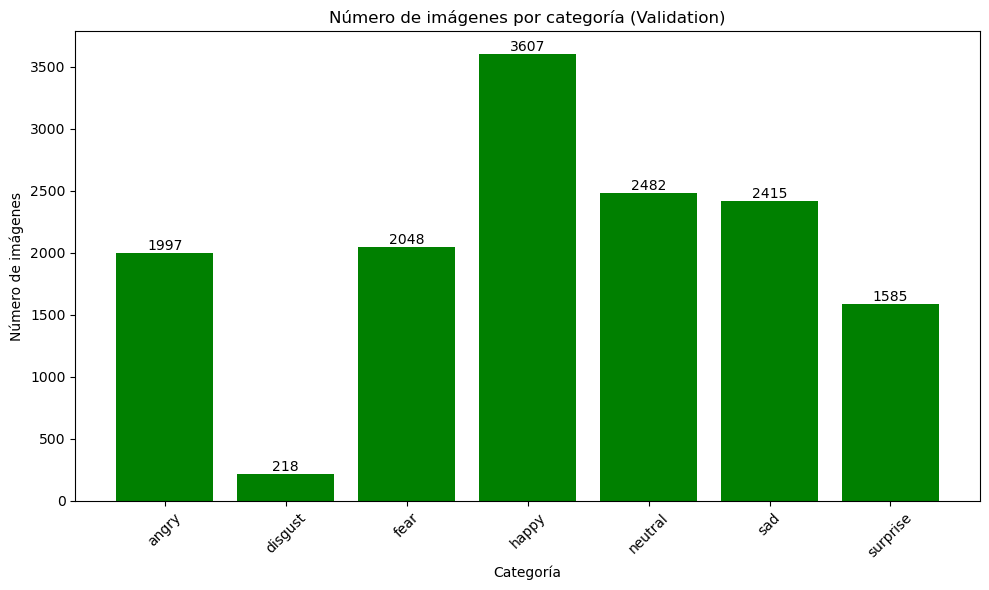

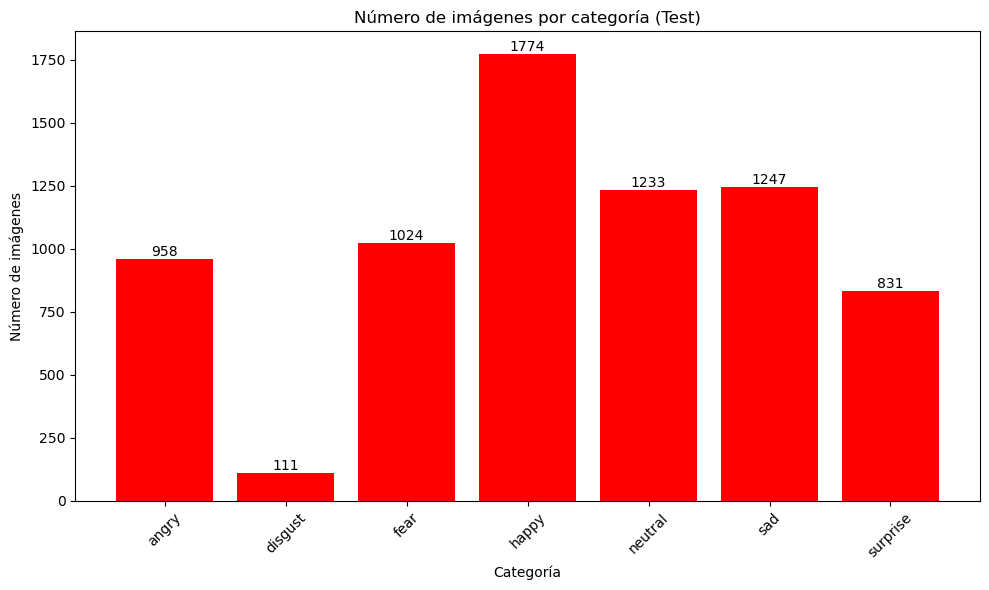

In [4]:
#Training
plt.figure(figsize=(10, 6))
plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
bars = plt.bar(train_category_counts.keys(), train_category_counts.values(), color='blue')
plt.title('Número de imágenes por categoría (Train)')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

#Validation
plt.figure(figsize=(10, 6))
plt.bar(validation_category_counts.keys(), validation_category_counts.values(), color='green')
bars = plt.bar(validation_category_counts.keys(), validation_category_counts.values(), color='green')
plt.title('Número de imágenes por categoría (Validation)')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

#Test
plt.figure(figsize=(10, 6))
plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
bars = plt.bar(test_category_counts.keys(), test_category_counts.values(), color='red')
plt.title('Número de imágenes por categoría (Test)')
plt.xlabel('Categoría')
plt.ylabel('Número de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

### CNN from scratch

In [5]:

# Define data directories
train_dir = "../data/train1"
validation_dir = "../data/validation"
test_dir = "../data/test"

# Image dimensions and other parameters
img_width, img_height = 150, 150
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
# Generate batches of image data (train and validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 14357 images belonging to 7 classes.
Found 14352 images belonging to 7 classes.


In [6]:
from tensorflow.keras import layers

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_filters_1', values=[16,32, 64, 96, 128]),
        kernel_size=hp.Choice('conv_kernel_1', values=[3, 5]),
        activation='relu',
        input_shape=(img_width, img_height, 3),
        padding='same'
    ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    # Add additional convolutional layers
    for i in range(hp.Int('num_conv_layers', 1, 6)):  # Adjust the range for the number of convolutional layers
        model.add(layers.Conv2D(
            filters=hp.Choice(f'conv_filters_{i+2}', values=[16,32, 64, 96, 128]),
            kernel_size=hp.Choice(f'conv_kernel_{i+2}', values=[3, 5]),
            activation='relu',
            padding='same'
        ))
        model.add(layers.MaxPooling2D(pool_size=(2, 2),padding='same'))

    model.add(layers.Flatten())

    # Add dense layers
    for i in range(hp.Int('num_dense_layers', 1, 4)):  # Adjust the range for the number of dense layers
        model.add(layers.Dense(
            units=hp.Choice(f'dense_units_{i+1}', values=[32, 64, 96, 128,256]),
            activation='relu'
        ))

    model.add(layers.Dense(7, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [7]:
from keras_tuner.tuners import BayesianOptimization


In [8]:
from keras import callbacks
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=200,
    executions_per_trial=1,
    overwrite=False,
    directory='tuner_results',
    project_name='cnn_tuning'
)


Reloading Tuner from tuner_results\cnn_tuning\tuner0.json


In [18]:

# Perform Hyperparameter Tuning
tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks.EarlyStopping(patience=5, monitor='val_accuracy')]
)

Trial 88 Complete [00h 09m 00s]
val_accuracy: 0.5571189522743225

Best val_accuracy So Far: 0.5798272490501404
Total elapsed time: 16h 24m 04s

Search: Running Trial #89

Value             |Best Value So Far |Hyperparameter
16                |16                |conv_filters_1
3                 |3                 |conv_kernel_1
6                 |5                 |num_conv_layers
32                |64                |conv_filters_2
3                 |3                 |conv_kernel_2
3                 |3                 |num_dense_layers
64                |128               |dense_units_1
64                |96                |dense_units_2
96                |96                |dense_units_3
64                |96                |dense_units_4
128               |64                |conv_filters_3
5                 |5                 |conv_kernel_3
128               |128               |conv_filters_4
5                 |3                 |conv_kernel_4
128               |96                |c

KeyboardInterrupt: 

In [17]:
tuner.results_summary()

Results summary
Results in tuner_results\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 063 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 5
conv_filters_2: 64
conv_kernel_2: 3
num_dense_layers: 3
dense_units_1: 128
dense_units_2: 96
dense_units_3: 96
dense_units_4: 96
conv_filters_3: 64
conv_kernel_3: 5
conv_filters_4: 128
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 3
conv_filters_6: 64
conv_kernel_6: 3
conv_filters_7: 64
conv_kernel_7: 5
Score: 0.5798272490501404

Trial 062 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 5
conv_filters_2: 64
conv_kernel_2: 3
num_dense_layers: 2
dense_units_1: 128
dense_units_2: 96
dense_units_3: 96
dense_units_4: 96
conv_filters_3: 96
conv_kernel_3: 5
conv_filters_4: 96
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 3
conv_filters_6: 64
conv_kernel_6: 3
conv_filters_7: 96
conv_kernel_7: 3
Score: 0.5782948136329651

Trial 075 summary
Hyper

In [15]:
tuner.get_best_models()[0]

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

In [10]:
# Get Best Model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

# Evaluate Best Model
loss, accuracy = best_model.evaluate(test_generator, verbose=2)
print(f"Test Accuracy: {accuracy}")

Best Hyperparameters: {'conv_filters_1': 16, 'conv_kernel_1': 3, 'num_conv_layers': 5, 'conv_filters_2': 64, 'conv_kernel_2': 3, 'num_dense_layers': 3, 'dense_units_1': 128, 'dense_units_2': 96, 'dense_units_3': 96, 'dense_units_4': 96, 'conv_filters_3': 64, 'conv_kernel_3': 5, 'conv_filters_4': 128, 'conv_kernel_4': 3, 'conv_filters_5': 96, 'conv_kernel_5': 3, 'conv_filters_6': 64, 'conv_kernel_6': 3, 'conv_filters_7': 64, 'conv_kernel_7': 5}
113/113 - 9s - loss: 1.1956 - accuracy: 0.5798 - 9s/epoch - 76ms/step
Validation Accuracy: 0.5798272490501404


In [20]:
best_hyperparameters.get('num_conv_layers')

5

In [21]:
best_hyperparameters.get('num_dense_layers')

3

In [22]:
tuner.results_summary()

Results summary
Results in tuner_results\cnn_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 063 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 5
conv_filters_2: 64
conv_kernel_2: 3
num_dense_layers: 3
dense_units_1: 128
dense_units_2: 96
dense_units_3: 96
dense_units_4: 96
conv_filters_3: 64
conv_kernel_3: 5
conv_filters_4: 128
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 3
conv_filters_6: 64
conv_kernel_6: 3
conv_filters_7: 64
conv_kernel_7: 5
Score: 0.5798272490501404

Trial 062 summary
Hyperparameters:
conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 5
conv_filters_2: 64
conv_kernel_2: 3
num_dense_layers: 2
dense_units_1: 128
dense_units_2: 96
dense_units_3: 96
dense_units_4: 96
conv_filters_3: 96
conv_kernel_3: 5
conv_filters_4: 96
conv_kernel_4: 3
conv_filters_5: 96
conv_kernel_5: 3
conv_filters_6: 64
conv_kernel_6: 3
conv_filters_7: 96
conv_kernel_7: 3
Score: 0.5782948136329651

Trial 075 summary
Hyper